# Adaptive step size ODE filters


In `probnum`, we implement the step size adaptation scheme from Schober et al., 2019:

https://arxiv.org/pdf/1610.05261.pdf

We show how for the KF-IBM(1) Combo, they work very well (which is what they write in their paper) but also, how it doesn't quite generalise to other filters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from probnum.diffeq import lotkavolterra, filter_ivp, filter_ivp_h
from probnum.prob import RandomVariable, Normal, Dirac


### IBM(1) with KF

We start by showing how solving an IVP with adaptive steps works:

In [ ]:
initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
ivp = lotkavolterra([0., 20.], initrv)
ms, cs, ts = filter_ivp(ivp, tol=1e-1)
ms1, cs1 = ms[:, 0], cs[:, 0, 0]
ms2, cs2 = ms[:, 2], cs[:, 2, 2]

plt.plot(ts, ms1, label="Prey")
plt.plot(ts, ms2, label="Predators")
plt.legend()
plt.show()

Now lets repeat the previous plot, but this time we visualise the steps:

In [ ]:
initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
ivp = lotkavolterra([0., 20.], initrv)
ms, cs, ts = filter_ivp(ivp, tol=1e-3)
ms1, cs1 = ms[:, 0], cs[:, 0, 0]
ms2, cs2 = ms[:, 2], cs[:, 2, 2]

plt.plot(ts, ms1, label="Prey")
plt.plot(ts, ms2, label="Predators")
for t in ts:
    plt.axvline(t, linewidth=0.05, color="gray")
plt.legend()
plt.show()

Note how at the peaks, there are more steps taken than at the valleys. This is what we want. In fact, the standard deviation as a local error estimate behaves like the tolerance. Note that we only plot one of the standard deviations of the respective coordinates, since by choice of the method, they are equal.

In [ ]:
plt.semilogy(ts, np.sqrt(cs1), label="stdev")
plt.axhline(1e-3, color="gray", label="tol")
plt.legend()
plt.grid()
plt.show()

## Higher order priors

Higher order priors exhibit the curious phenomenon that the step size selection is agnostic of the order of the method. 

In [ ]:
initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
ivp = lotkavolterra([0., 10.], initrv)
ms, cs, ts1 = filter_ivp(ivp, tol=1e-3, which_prior="ibm1")
ms1, cs1 = ms[:, 0], cs[:, 0, 0]
ms2, cs2 = ms[:, 2], cs[:, 2, 2]

ms, cs, ts3 = filter_ivp(ivp, tol=1e-3, which_prior="ibm2")
ms3, cs3 = ms[:, 0], cs[:, 0, 0]
ms4, cs4 = ms[:, 2], cs[:, 2, 2]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax2.semilogy(ts1, np.sqrt(cs1))
ax2.set_title("IBM(1) prior: %u steps" % len(ts1))
ax1.semilogy(ts3, np.sqrt(cs3))
ax1.set_title("IBM(2) prior: %u steps" % len(ts3))
plt.show()

Both need roughly the same number of steps, even though the standard deviation of the IBM(2) prior is about 100 times smaller then the standard deviation of the IBM(1) prior. I suppose the reason is due to the choice of the whitened residual $\epsilon_n = S_n^{-1/2}r_n$ as an error estimate ($r_n$ is the residual at the current step). For IBM(2) priors, the residual is smaller than for the IBM(1) prior. In fact, we can guess how much smaller it is: 
the residual of IBM(1) is roughly $h^2$ and the residual of IBM(2) is roughly $h^3$. However, the innovation term $S_n$ for IBM(3) is (very loosely speaking) proportional to $h^3$, too, so the gain in error estimate is tiny.

## Other filters

Other filters have other issues. The innovation term of the extended Kalman filter incldues the Jacobian of the ODE r.h.s. $J_f$ and in fact, there seem to be settings where the innovation term is not even invertible without adding noise.

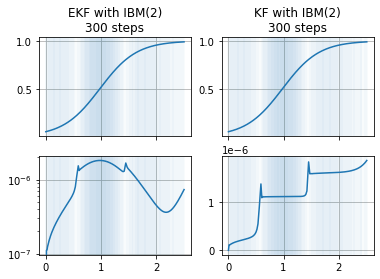

In [21]:
from probnum.diffeq import logistic

initrv = RandomVariable(distribution=Dirac(0.05*np.ones(1)))
ivp = logistic([0., 2.5], initrv)
ms, cs, ts1 = filter_ivp(ivp, tol=1e-3, which_prior="ibm2", which_filt="kf")
ms1, cs1 = ms[:, 0], cs[:, 0, 0]
ms2, cs2 = ms[:, 2], cs[:, 2, 2]

ms, cs, ts3 = filter_ivp(ivp, tol=1e-3, which_prior="ibm2", which_filt="ekf")
ms3, cs3 = ms[:, 0], cs[:, 0, 0]
ms4, cs4 = ms[:, 2], cs[:, 2, 2]


fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)
ax[0][0].plot(ts3, (ms3))
for t in ts3:
    ax[0][0].axvline(t, linewidth=0.1, alpha=0.5)
ax[0][0].set_title("EKF with IBM(2)\n%u steps" % len(ts3))
ax[0][0].grid()

ax[1][0].semilogy(ts3, np.sqrt(cs3))
for t in ts3:
    ax[1][0].axvline(t, linewidth=0.1, alpha=0.5)
ax[1][0].grid()

ax[0][1].plot(ts1, (ms1))
for t in ts1:
    ax[0][1].axvline(t, linewidth=0.1, alpha=0.5)
ax[0][1].set_title("KF with IBM(2)\n%u steps" % len(ts1))
ax[0][1].grid()


ax[1][1].plot(ts1, np.sqrt(cs1))
for t in ts1:
    ax[1][1].axvline(t, linewidth=0.1, alpha=0.5)
ax[1][1].grid()


plt.show()


